# Metaflow

Sometimes, we want to dream big! In this case, let's imagine we want to put all 3 examples ([preprocessing](example_preprocessing.ipynb), [1st-level](example_1stlevel.ipynb) and [normalization](example_normalize.ipynb)) into one big workflow, called **``metaflow``**. Like this, we would only need one script, to run a whole 1st-level fMRI analysis. **That's the power of Nipype!**

# Building the ``metaflow``

To build this ``metaflow``, we need to undertake the same steps as before.

## Imports
First things first, we need to import all interfaces and modules that we need.

In [1]:
%matplotlib inline
from os.path import join as opj
import json, os
from nipype.pipeline.engine import Workflow, Node, MapNode
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.algorithms.misc import Gunzip
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.afni import Resample
from nipype.interfaces.ants import ApplyTransforms
from nipype.interfaces.fsl import Info, MCFLIRT, FLIRT, ExtractROI, BET, FAST, ImageMaths
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.interfaces.spm import (Smooth, Normalize12, Level1Design,
                                   EstimateModel, EstimateContrast)

## Experiment parameters

As before, it's always a good idea to specify all experiment specific parameters at the beginning of your script.

In [2]:
experiment_dir = '/output'
output_dir = 'datasink_metaflow'
working_dir = 'workingdir'

# list of subject identifiers
subject_list = ['sub-01', 'sub-02'] #, 'sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10']

# Smoothing widths to apply
fwhm = [4, 8]

# TR of functional images
with open('/data/ds000114/task-fingerfootlips_bold.json', 'rt') as fp:
    task_info = json.load(fp)
TR = task_info['RepetitionTime']

# Template to normalize to for ANTs
templateANTs = '/data/ds000114/derivatives/fmriprep/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz'

# Template to normalize to for SPM
templateSPM = '/opt/spm12/spm12_mcr/spm/spm12/tpm/TPM.nii'

## Specify Nodes

Now, let's specify all nodes that we need.

### Nodes we need for preprocessing

It's **important** to notice, that we changed this section a bit from the one under [Example 1 Preprocessing](example_preprocessing.ipynb). Most of the preprocessing nodes were changed to ``MapNodes``. By sending the functional images of the preprocessing workflow through ``MapNodes`` we can make sure that arrive as an array list in the 1st-level Workflow.

In [3]:
# ExtractROI - skip dummy scans

extract = Node(ExtractROI(t_min=4, t_size=-1),
               output_type='NIFTI',
               name="extract")

# MCFLIRT - motion correction
mcflirt = Node(MCFLIRT(mean_vol=True,
                       save_plots=True,
                       output_type='NIFTI'),
               name="mcflirt")

# BET - strip the anatomical image
stripper = Node(BET(), name='stripper')

# FAST - get WM segmentation
fast = Node(FAST(), name='fast')

# ImageMaths - binarize the segmentation
binarize = Node(ImageMaths(op_string='-nan -thr 0.5 -bin'),
                name='binarize')

pickindex = lambda x, i: x[i]

# FLIRT - coregister functional images to anatomical images
mean2anat = Node(FLIRT(), name='mean2anat')
mean2anat.inputs.dof = 6

# FLIRT - Now use bbr cost function to improve the transform
mean2anatbbr = Node(FLIRT(), name='mean2anatbbr')
mean2anatbbr.inputs.dof = 6
mean2anatbbr.inputs.cost = 'bbr'
mean2anatbbr.inputs.schedule = opj(os.getenv('FSLDIR'),
                                            'etc/flirtsch/bbr.sch')
# Smooth - image smoothing
smooth = Node(Smooth(), name="smooth")
smooth.iterables = ("fwhm", fwhm)

### Nodes we need for the 1-st level analysis

In [4]:
# SpecifyModel - Generates SPM-specific Model
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=128),
                 name="modelspec")

# Level1Design - Generates an SPM design matrix
level1design = Node(Level1Design(bases={'hrf': {'derivs': [1, 0]}},
                                 timing_units='secs',
                                 interscan_interval=TR,
                                 model_serial_correlations='FAST'),
                    name="level1design")

# EstimateModel - estimate the parameters of the model
level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level1estimate")

# EstimateContrast - estimates contrasts
level1conest = Node(EstimateContrast(), name="level1conest")

# FLIRT - apply the transform
applyxfm = MapNode(FLIRT(output_type='NIFTI',
                         out_matrix_file='local.mat',
                         apply_xfm=True), name="applyxfm", iterfield=['in_file'])

# Merge - Gather all the contrast images
def merge_files(spmT, con, spmF, ess):
    out_files = []
    splits = []
    for ii in [spmT, con, spmF, ess]:
        out_files.extend(ii)
        splits.append(len(ii))
    return out_files, splits

merge = Node(Function(input_names=["spmT", "con", "spmF", "ess"],
                      output_names=['out_files', 'splits'],
                      function=merge_files),
             name='merge')


def split_files(in_files, splits):
    spmT = in_files[:splits[0]]
    con = in_files[splits[0]:(splits[0] + splits[1])]
    spmF = in_files[(splits[0] + splits[1]):(splits[0] + splits[1] + splits[2])]
    ess = in_files[(splits[0] + splits[1] + splits[2]):]
    contrast = con + ess
    statistics = spmT + spmF
    return contrast, statistics

split = Node(Function(input_names=['in_files', 'splits'],
                      output_names=['contrast', 'statistics'],
                    function=split_files),
             name='split')


### Node we need for the normalization with ANTs

Don't forget to link to the right template.

In [5]:
# Apply Transformation - applies the normalization matrix to contrast images
apply2con = MapNode(ApplyTransforms(args='--float',
                                    input_image_type=3,
                                    interpolation='BSpline',
                                    invert_transform_flags=[False],
                                    num_threads=1,
                                    reference_image=templateANTs,
                                    terminal_output='file'),
                    name='apply2con', iterfield=['input_image'])

### Nodes we need for the normalization with SPM

Don't forget to link to the right template.

In [6]:
# Gunzip - unzip the anatomical image
gunzip = Node(Gunzip(), name="gunzip")

# Normalize - normalizes functional and structural images to the MNI template
normalize = Node(Normalize12(jobtype='estwrite',
                             tpm=templateSPM,
                             write_voxel_sizes=[2, 2, 2]),
                 name="normalize")

## Specify GLM contrasts

In [7]:
# Condition names
condition_names = ['Finger', 'Foot', 'Lips']

# Contrasts
cont01 = ['average',        'T', condition_names, [1/3., 1/3., 1/3.]]
cont02 = ['Finger',         'T', condition_names, [1, 0, 0]]
cont03 = ['Foot',           'T', condition_names, [0, 1, 0]]
cont04 = ['Lips',           'T', condition_names, [0, 0, 1]]
cont05 = ['Finger > others','T', condition_names, [1, -0.5, -0.5]]
cont06 = ['Foot > others',  'T', condition_names, [-0.5, 1, -0.5]]
cont07 = ['Lips > others',  'T', condition_names, [-0.5, -0.5, 1]]

cont08 = ['activation',     'F', [cont02, cont03, cont04]]
cont09 = ['differences',    'F', [cont05, cont06, cont07]]

contrast_list = [cont01, cont02, cont03, cont04, cont05, cont06, cont07, cont08, cont09]

## Specify GLM Model

In [8]:
def subjectinfo(subject_id):

    import pandas as pd
    from nipype.interfaces.base import Bunch
    
    trialinfo = pd.read_table('/data/ds000114/task-fingerfootlips_events.tsv')
    trialinfo.head()
    conditions = []
    onsets = []
    durations = []

    for group in trialinfo.groupby('trial_type'):
        conditions.append(group[0])
        onsets.append(list(group[1].onset - 10)) # subtracting 10s due to removing of 4 dummy scans
        durations.append(group[1].duration.tolist())

    subject_info = [Bunch(conditions=conditions,
                          onsets=onsets,
                          durations=durations,
                         )]

    return subject_info  # this output will later be returned to infosource

# Get Subject Info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id'],
                               output_names=['subject_info'],
                               function=subjectinfo),
                      name='getsubjectinfo')

## Specify input & output stream

This is one of the more important parts of the ``metaflows``, as we can merge the ``IdentityInterface``, ``SelectFiles`` and ``Datasink`` nodes into one each. 

It's **important** to mention here, that some of the template files, such as ``mc_par`` from preprocessing or ``cons`` from normalization are not used as inputs for the ``selectfiles`` node. This is because we will link the different workflows directly to each other, later on. Also, ``func_file`` template now looks for files with ``{subject_id}_task-flanker_*_bold.nii.gz'`` instead of ``{subject_id}_task-flanker_{session_id}_bold.nii.gz'``.

In [9]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'contrasts'], 
                                    contrasts=contrast_list),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list)]


# SelectFiles - to grab the data (alternativ to DataGrabber)
anat_file = opj('derivatives', 'fmriprep', '{subject_id}', 'anat', '{subject_id}_t1w_preproc.nii.gz')
func_file = opj('{subject_id}', 'ses-test', 'func',
                '{subject_id}_ses-test_task-fingerfootlips_bold.nii.gz')
transform_file = opj('/data/ds000114/derivatives/fmriprep/', '{subject_id}', 'anat',
                    '{subject_id}_t1w_space-mni152nlin2009casym_warp.h5')


templates = {'anat': anat_file,
             'func': func_file,
             'transform' : transform_file}
selectfiles = Node(SelectFiles(templates,
                               base_directory='/data/ds000114'),
                   name="selectfiles")



# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")


# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
# Use the following DataSink output substitutions
substitutions = [('_subject_id_', ''),
                 ('_task_name_', '/task-'),
                 ('_fwhm_', 'fwhm-'),
                 ('_mcf.nii_mean_reg', '_mean'),
                 ('.nii.par', '.par'),
                 ('_flirt', ''),
                 ]

    
subjFolders = [('_fwhm_id_%s%s' % (f, sub), '%s/fwhm-%s' % (sub, f))
               for f in fwhm
               for sub in subject_list]
subjFolders += [('_apply2con%s/' % (i), '') for i in range(9)]
substitutions.extend(subjFolders)

datasink.inputs.substitutions = substitutions

datasink.inputs.regexp_substitutions = [('_applyxfm[0-9]+/', '')]


#subjFolders = [('_coreg_step1%s/' % i , '') for i in [0, 1]]
#subjFolders += [('_mcflirt%s/' % i , '') for i in [0, 1]]
#subjFolders += [('_apply2con%s/' % i , '') for i in range(len(contrast_list))]

#subjFolders += [('_fwhm_%s/_smooth%i' % (f, i), 'fwhm%s' % i)
#                for f in fwhm for i in [0, 1]]
#subjFolders += [('%s/_fwhm_%s' % (sub, f), '%s_fwhm%s' % (sub, f))
#                for sub in subject_list for f in fwhm]
#substitutions.extend(subjFolders)

## Specify Workflows

As before, we will define the different workflows from the example. The only difference for now is that we won't connect the input and output nodes within the workflows. We will establish the needed connections, but at a later stage, while creating the ``metaflow``.

### Create Preprocessing Workflow

In [10]:
# Create a preprocessing workflow
preproc = Workflow(name='preproc')
preproc.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the preprocessing workflow
preproc.connect([(extract, mcflirt, [('roi_file', 'in_file')]),
#                 (selectfiles, stripper, [('anat', 'in_file')]),
                 (stripper, fast, [('out_file', 'in_files')]),
                 (fast, binarize, [(('partial_volume_files', pickindex, 2), 'in_file')]),
                 
                 (mcflirt, mean2anat, [('mean_img', 'in_file')]),
                 (stripper, mean2anat, [('out_file', 'reference')]),

                 (mcflirt, mean2anatbbr, [('mean_img', 'in_file')]),
                 (binarize, mean2anatbbr, [('out_file', 'wm_seg')]),
                 (mean2anat, mean2anatbbr, [('out_matrix_file', 'in_matrix_file')]),
                 
                 (mcflirt, smooth, [('out_file', 'in_files')]),
                 ])

### Create 1st-level Workflow

In [11]:
# Initiation of the 1st-level analysis workflow
l1analysis = Workflow(name='l1analysis')
l1analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 1st-level analysis components
l1analysis.connect([(getsubjectinfo, modelspec, [('subject_info',
                                                  'subject_info')]),
                    (modelspec, level1design, [('session_info',
                                                'session_info')]),
                    (level1design, level1estimate, [('spm_mat_file',
                                                     'spm_mat_file')]),
                    (level1estimate, level1conest, [('spm_mat_file',
                                                     'spm_mat_file'),
                                                    ('beta_images',
                                                     'beta_images'),
                                                    ('residual_image',
                                                     'residual_image')]),
                    (level1conest, merge, [('spmT_images', 'spmT'),
                                           ('con_images', 'con'),
                                           ('spmF_images', 'spmF'),
                                           ('ess_images', 'ess'),
                                          ]),
                    (merge, applyxfm, [('out_files', 'in_file')]),
                    (applyxfm, split, [('out_file', 'in_files')]),
                    (merge, split, [('splits', 'splits')])
                    ])

### Create the two normalization Workflows

In [12]:
# Specify Normalization-Workflow & Connect Nodes
spmflow = Workflow(name='spmflow')
spmflow.base_dir = opj(experiment_dir, working_dir)

# Connect up SPM normalization components
spmflow.connect([(gunzip, normalize, [('out_file', 'image_to_align')])])



# Specify Normalization-Workflow & Connect Nodes
spmflow = Workflow(name='spmflow')
spmflow.base_dir = opj(experiment_dir, working_dir)

# Connect up SPM normalization components
spmflow.connect([(gunzip, normalize, [('out_file', 'image_to_align')]),
                 ])

In [13]:
# Initiation of the ANTs normalization workflow
antsflow = Workflow(name='antsflow')
antsflow.base_dir = opj(experiment_dir, working_dir)

# Connect up the ANTs normalization components
antsflow.add_nodes([apply2con])


You might have realized that the ``antsflow`` from example 3, takes only inputs directly from the ``selectfiles`` node. As the ``selectfiles`` node of this workflow will be added to the ``metaflow``, we will not establish any connections here. But we can nonetheless already add the ``apply2con`` node to the ``antsflow``.

## Build the ``metaflow`` (NEW)

This is a new step, as we now connect workflows to each other, and not just to nodes.

### First step, create the meta workflow.

In [14]:
metaflow = Workflow(name='metaflow')
metaflow.base_dir = opj(experiment_dir, working_dir)

### Second step, connect the workflows to each other

You will notice that connecting workflows to each other is similar to connecting nodes, but not exactly. For once, you have to specify which workflows you want to connect, and than also which nodes the input and output fields are belonging to.

In [15]:
metaflow.connect([(preproc, l1analysis, [('smooth.smoothed_files',
                                          'modelspec.functional_runs'),
                                         ('mcflirt.par_file',
                                          'modelspec.realignment_parameters'),
                                         ('mean2anatbbr.out_matrix_file',
                                          'applyxfm.in_matrix_file'),
                                         ]),
                  (l1analysis, spmflow, [('split.contrast',
                                          'normalize.apply_to_files')]),
                  (l1analysis, antsflow, [('split.contrast',
                                           'apply2con.input_image')])
                  ])

### Third step, connecting the input & output stream to the ``metaflow``

In [16]:
metaflow.connect([(infosource, selectfiles, [('subject_id',
                                              'subject_id'),
                                             ]),
                  (selectfiles, preproc, [('func', 'extract.in_file'),
                                          ('anat', 'stripper.in_file'),
                                          ('anat', 'mean2anatbbr.reference')]),
                  (infosource, l1analysis, [('subject_id',
                                             'getsubjectinfo.subject_id'),
                                            ('contrasts',
                                             'level1conest.contrasts')]),
                  (selectfiles, l1analysis, [('anat', 'applyxfm.reference')]),

                  (selectfiles, spmflow, [('anat', 'gunzip.in_file')]),
                  (selectfiles, antsflow, [('transform',
                                            'apply2con.transforms')]),

                  (preproc, datasink, [('mcflirt.par_file', 'preproc.@par'),
                                       ('mean2anat.out_file', 'preproc.@coregmean'),
                                       ('mean2anatbbr.out_matrix_file', 'preproc.@coregmatrix'),
                                       ('smooth.smoothed_files', 'preproc.@smooth'),
                                       ]),
                  (l1analysis, datasink, [('level1conest.spm_mat_file',
                                           '1stLevel.@spm_mat'),
                                          #('applyxfm.out_file',
                                          #'1stLevel.@contrasts')
                                          ]),

                  (spmflow, datasink, [('normalize.normalized_files',
                                        'norm_spm.@files'),
                                       ('normalize.normalized_image',
                                        'norm_spm.@image')]),
                  (antsflow, datasink, [('apply2con.output_image',
                                         'norm_ants.@con')]),
                  ])

## Visualize the workflow

170809-02:50:37,548 workflow INFO:
	 Generated workflow graph: /output/workingdir/metaflow/graph.dot.png (graph2use=colored, simple_form=True).


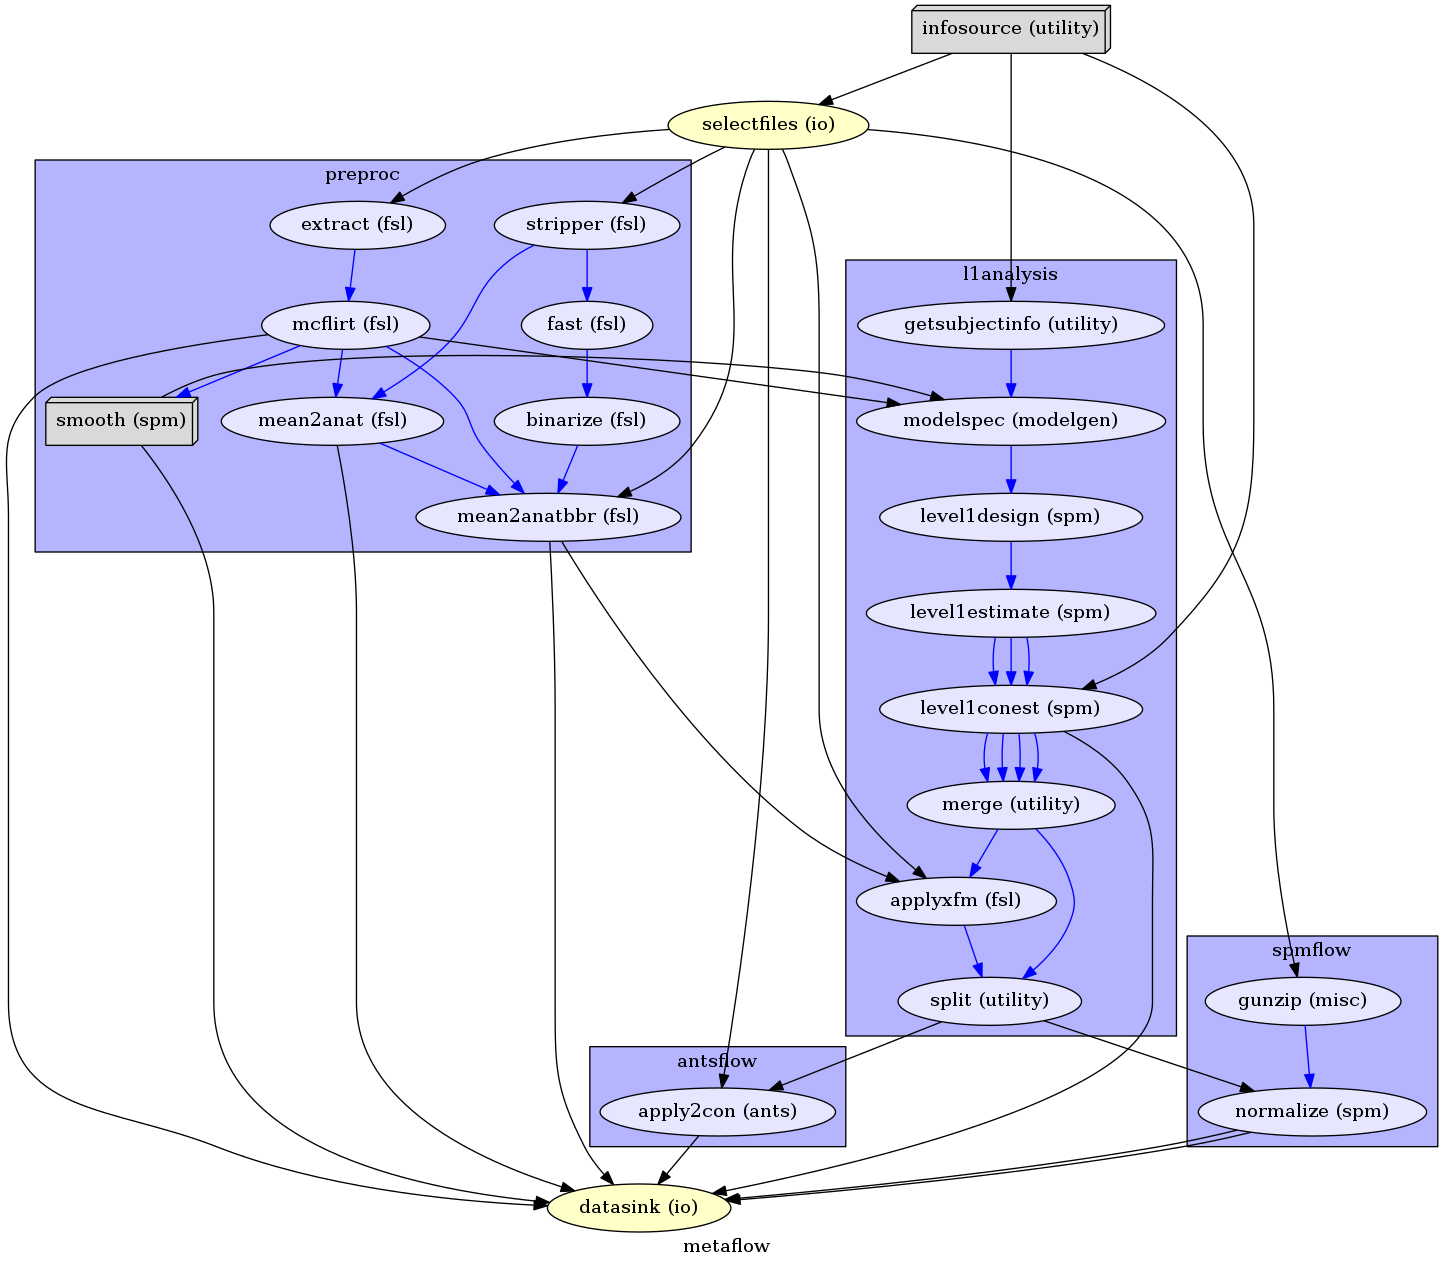

In [17]:
# Create preproc output graph
metaflow.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(metaflow.base_dir, 'metaflow', 'graph.dot.png'))

170809-02:50:38,705 workflow INFO:
	 Generated workflow graph: /output/workingdir/metaflow/graph.dot.png (graph2use=flat, simple_form=True).


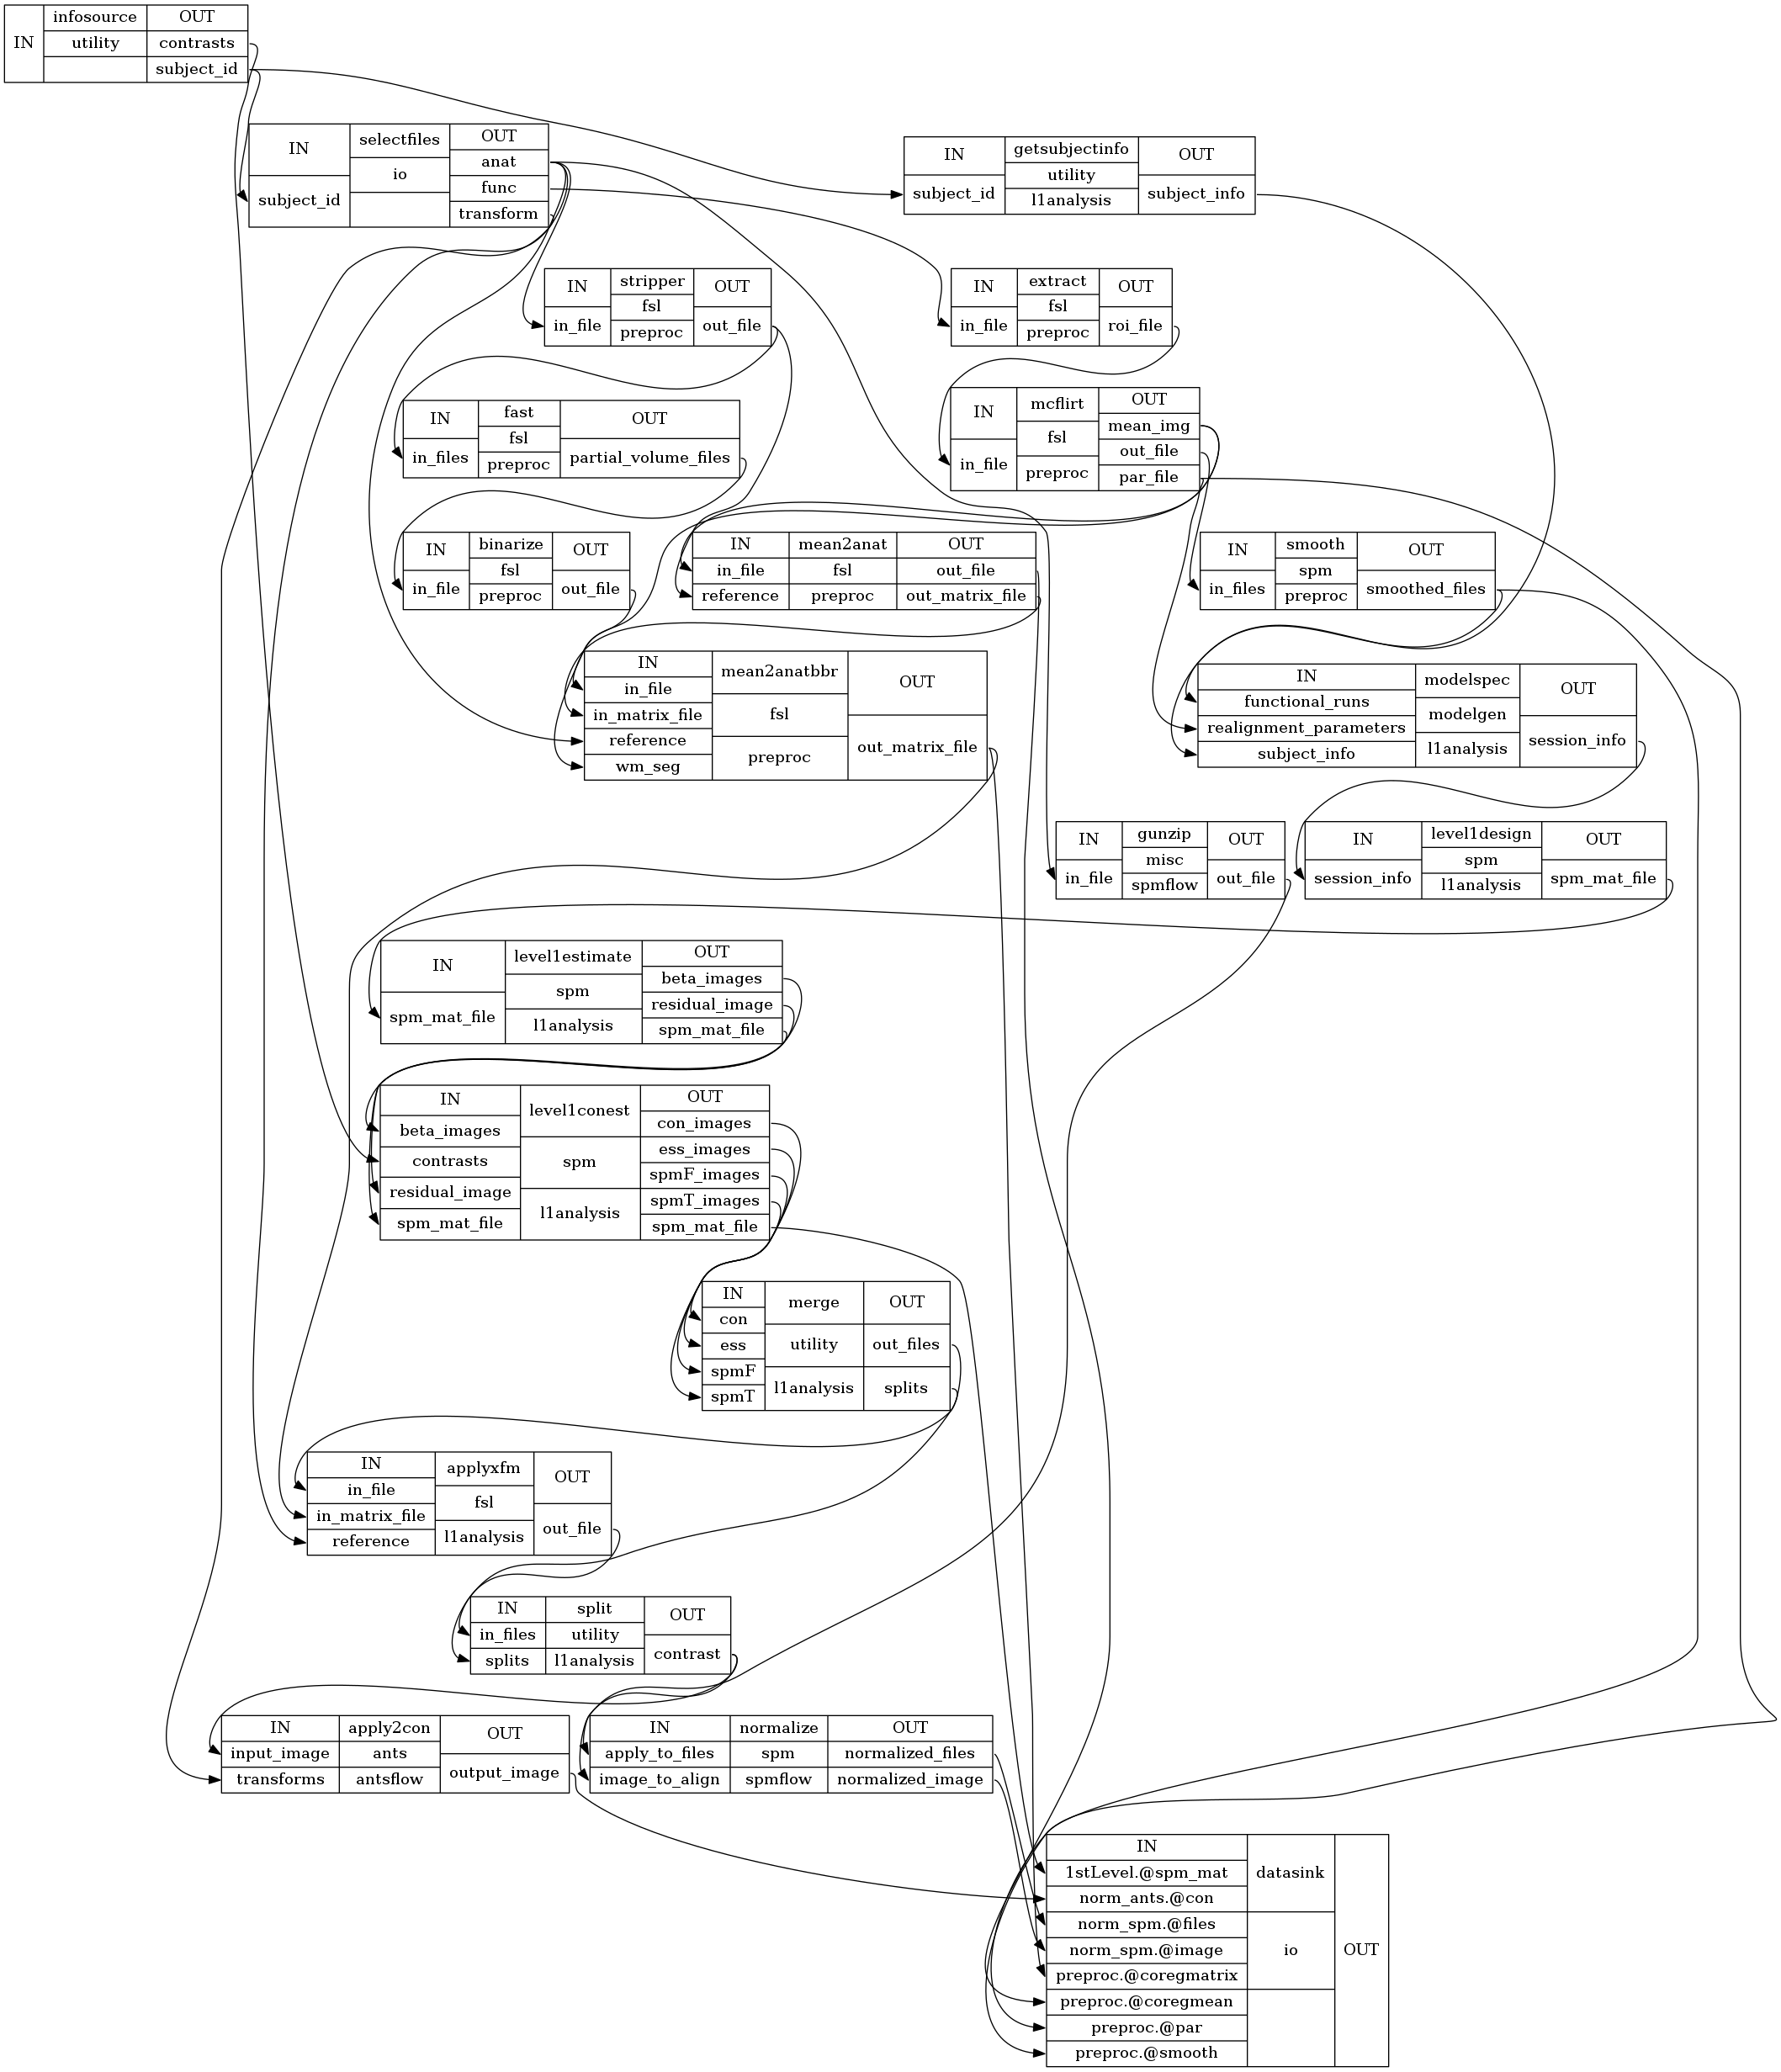

In [18]:
# Visualize the detailed graph
metaflow.write_graph(graph2use='flat', format='png', simple_form=True)
Image(filename=opj(metaflow.base_dir, 'metaflow', 'graph_detailed.dot.png'))

##  Run the Workflow

In [19]:
metaflow.run('MultiProc', plugin_args={'n_procs': 4})

170809-02:50:39,57 workflow INFO:
	 Workflow metaflow settings: ['check', 'execution', 'logging']
170809-02:50:39,263 workflow INFO:
	 Running in parallel.
170809-02:50:39,271 workflow INFO:
	 Executing: getsubjectinfo.b1 ID: 0
170809-02:50:39,280 workflow INFO:
	 [Job finished] jobname: getsubjectinfo.b1 jobid: 0
170809-02:50:39,284 workflow INFO:
	 Executing: selectfiles.b1 ID: 1
170809-02:50:39,295 workflow INFO:
	 Executing: getsubjectinfo.b0 ID: 32
170809-02:50:39,298 workflow INFO:
	 Executing node selectfiles.b1 in dir: /output/workingdir/metaflow/_subject_id_sub-02/selectfiles
170809-02:50:39,315 workflow INFO:
	 [Job finished] jobname: getsubjectinfo.b0 jobid: 32
170809-02:50:39,320 workflow INFO:
	 Executing: selectfiles.b0 ID: 33
170809-02:50:39,339 workflow INFO:
	 Executing node selectfiles.b0 in dir: /output/workingdir/metaflow/_subject_id_sub-01/selectfiles
170809-02:50:39,419 workflow INFO:
	 [Job finished] jobname: selectfiles.b1 jobid: 1
170809-02:50:39,426 workflow I

Now we can check if our results are the same as previously.

In [20]:
%matplotlib inline
from nilearn.plotting import plot_stat_map
import numpy as np
import pylab as plt
anatimg = '/data/ds000114/derivatives/fmriprep/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz'

/opt/conda/envs/neuro/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


First, we will plot 1st level analysis for `sub-01` and contrast **average**.

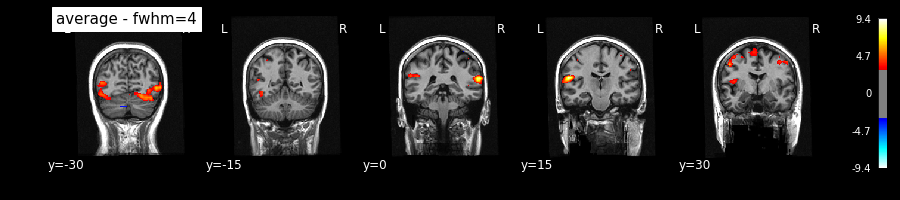

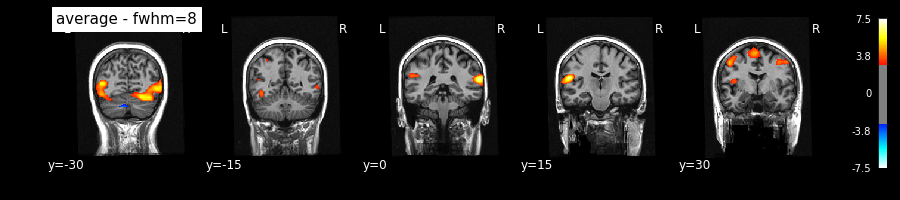

In [21]:
from nilearn.plotting import plot_stat_map
anatimg = '/data/ds000114/derivatives/fmriprep/sub-02/anat/sub-02_t1w_preproc.nii.gz'
plot_stat_map(
    '/output/datasink_metaflow/1stLevel/sub-02/fwhm-4/spmT_0001.nii', title='average - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-30, -15, 0, 15, 30), dim=-1)
plot_stat_map(
    '/output/datasink_metaflow/1stLevel/sub-02/fwhm-8/spmT_0001.nii', title='average - fwhm=8',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-30, -15, 0, 15, 30), dim=-1)

And now we will check the results of normalization.

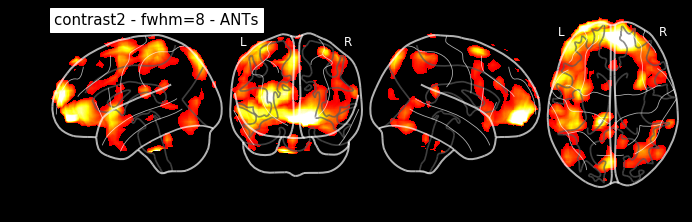

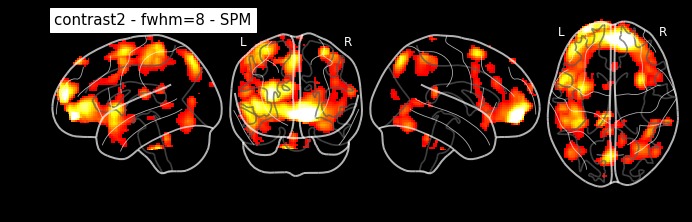

In [22]:
from nilearn.plotting import plot_glass_brain
plot_glass_brain(
    '/output/datasink_metaflow/norm_ants/sub-02/fwhm-8/con_0002_trans.nii',
    threshold=1, display_mode='lyrz', black_bg=True, vmax=3, title='contrast2 - fwhm=8 - ANTs')
plot_glass_brain(
    '/output/datasink_metaflow/norm_spm/sub-02/fwhm-8/wcon_0002.nii',
    threshold=1, display_mode='lyrz', black_bg=True, vmax=3, title='contrast2 - fwhm=8 - SPM')